# Random pattern animator

Generate moving random patterns using group theory. Tech 411.05 *Patterns and Symmetry*, University of New Hampshire, J. Gibson, 2024.

![C4](C4f-small.png)  ![C5](C5f-small.png) ![C6](C6f-small.png)



## The code

Execute this code cell (hit shift-enter) to define the pattern-generating functions.

For explanation of the math and code, refer to notebook `random-pattern-explicator.ipynb`.

In [1]:
using LinearAlgebra, Plots

"""
    rotation(θ)

return 2 x 2 rotation matrix that rotates plane by angle θ
"""
rotation(θ) = [cos(θ) -sin(θ); sin(θ) cos(θ)]

"""
    dihedralgroup(n, flip=true)

Generate symmetries of the n-gon that rotate and flip the n-gon in the plane.
The return value is an array of n or 2n matrices representing the elements of the group.
"""
function dihedralgroup(n, flip=true)    
    S = [-1 0; 0 1]                 # a reflection about y axis
    I = [1.0 0.0; 0.0 1.0]          # the identity
    Dn = fill(I, flip ? 2n : n) # allocate an array of 2n or n matrices
    
    for k=1:n
        Dn[k] = rotation(2(k-1)π/n) # set Dn[k] to rotation by θ = 2(k-1)π/n
        if flip
            Dn[k+n] = S*Dn[k]       # set Dn[k+n] to reflection of Dn[k]
        end
    end
    Dn
end

"""
    symmetrize(X, G)

Symmetrize a set of data points X by symmetry group G. The return value
is a matrix containing all columns of X mapped by all matrices in G
"""
function symmetrize(X, G)
    m,nX = size(X)  # nX is number of data points
    nG = length(G)  # nG is number elements in group
    
    GX = fill(0.0, 2, nX*nG) # allocate a matrix for G applied to X
    
    for j in 1:nX      # for each datapoint in X...
        for k in 1:nG  # ...and for each matrix in the group...
            GX[:, (j-1)*nG + k] = G[k]*X[:,j] # ...map the jth datapoint by the kth matrix
        end
    end
    GX
end

"""
    f(x, X, a=1, k=1)

return 1/N sum_j cos(k|x-xj|) exp(-a|x-xj|^2) where 
  x is a 2d vector 
  xj is the jth column of 2 x N matrix X
"""
function f(x, X, a=1, k=1)
    s = 0.0
    N = size(X, 2)
    for j in 1:N
        r = norm(x-X[:,j])
        s += cos(k*r)*exp(-a*(r^2))
    end
    s/N
end

"""
    plotpattern(n, flip, X, a, k, width, levels, colormap)    
     
Generate a symmetric pattern based on 
  n : use symmetry group of n-gon
  flip : boolean, use / don't use reflection symmetries
  X : 2 x N matrix of data points, each column of X is a point in the plane 
  a : scale of blobs, exp(-a r^2)
  k : scale of oscillations, cos(k r^2)
  width : width and height of plot axes
  levels : number or values of contour levels
  colormap : colormap for contour plot     
"""
function plotpattern(n, flip, X, a, k, width, levels, colormap) 
    # symmetrize the data points X with the symmetries of the n-gon
    G = dihedralgroup(n, flip)
    Xsymm = symmetrize(X, G)

    # evaluate f(x, Xsymm, a, k) over a grid of points x=[x1;x2]
    w = width 
    x1grid = range(-w, w, length=100)
    x2grid = range(-w, w, length=100)
    zgrid = [f([x1;x2], Xsymm, a, k) for x2 in x2grid, x1 in x1grid]

    # make a contour plot of zgrid = f(x, Xsymm, a, k)
    zscale = maximum(abs.(zgrid))
    contourf(x1grid, x2grid, zgrid/zscale, color=colormap, levels=levels, legend=:none)
    p1 = plot!(legend=:none, xlim=(-w,w), ylim=(-w,w), size=(400,400), aspect_ratio=1, showaxis=false)

    p2 = scatter(Xsymm[1,:], Xsymm[2,:], xlim=(-w,w), ylim=(-w,w), label="", aspect_ratio=1)
    plot(p1,p2, size=(800,400))
end

"""
animatepattern(n, flip, X, a, k, ω, t, width, levels, colormap, speed=16, saveframes=false)
  Animate a symmetric pattern based on 
     ngon : use symmetry group of n-gon
     flip : boolean, use / don't use reflection symmetries
     X : 2 x N matrix of data points, each column xj is a point on the plane
     a : univariate function a(t) for scale of blobs exp(-a(t) |x-x_j|)
     k : univariate function k(t) for scale of ripples cos(k(t) |x-xj|^2)
     ω : vector of N rotation rates for the N data points X
     t : vector of uniformly space time values for time-varying functions 
     width : width and height of plot axes
     levels : number or values of contour levels
     colormap : colormap for contour plot
     speed : sleep for 1/16 second between images (plotting is slow, so doesn't affect much)
"""
function animatepattern(n, flip, X, a, k, ω, t, width, levels, colormap, speed=16, saveframes=false)
    dt = t[2]-t[1]        # increment of time
    R = rotation.(ω*dt)   # vector of incremental rotation matrices, one for each data point
 
    Nx = size(X,2)
    Xt = copy(X)
    
    for i in 1:length(t)
        p = plotpattern(n, flip, Xt, a(t[i]), k(t[i]), width, levels, colormap)
        if saveframes 
            savefig("frame-$(n+1000).png")
        end
        #p = plot!(title="$(Int(round(t[i]/16)))")
        IJulia.clear_output(true)
        display(p)
        sleep(1/speed)
        
        for j=1:Nx
            Xt[:,j] = R[j]*Xt[:,j]
        end
    end
end

animatepattern

## Make patterns

Generate patterns by executing this cell with different parameters. 

In [8]:
# pattern parameters
ngon = 4  # n-gon dihedral group
Npts = 3  # number of random points
a0 = 3    # scale of blobs (larger a, narrower blobs)
k0 = 5    # scale of ripples (larger k, more rapid ripples)
s = 1     # scale of data points (larger s, further spread out)
width = 4 # width of plot: -width < x < width, -width < y < width

flip = true  # do or don't include mirror symmetry 
speed = 16   # if animation is too fast, reduce this value
levels = -1:.3:1  # number or values of contour levels
colormap =  :seaborn_colorblind6 # :Set1_4 #:PuRd_5  #:seaborn_colorblind6  #:Paired_8 (search on "Julia Plots colormaps" to find other color palettes)

X = randn(2, Npts)
dt = pi/256
t = 0:dt:2pi

# some choices for rotation rates
#ω = 1.5*(2*rand(Npts).-1) # random rotation rates for data points 
#ω = ω .- sum(ω)/Npts      # remove mean rotation
#ω = rand(Int, Npts) .% 6 .+ 1
ω = (rand(Int,Npts) .% 4 .+ 1).* (-1).^(rand(Int,Npts) .% 2)
if !flip
    ω = ω .- sum(ω)/Npts      # remove mean rotation
end

# time variation of blob scale a(t) and ripple scale k(t)
a(t) = a0*(1 .- 2/3*cos.(t))
k(t) = k0*(1 .- 2/3*cos.(2*t));

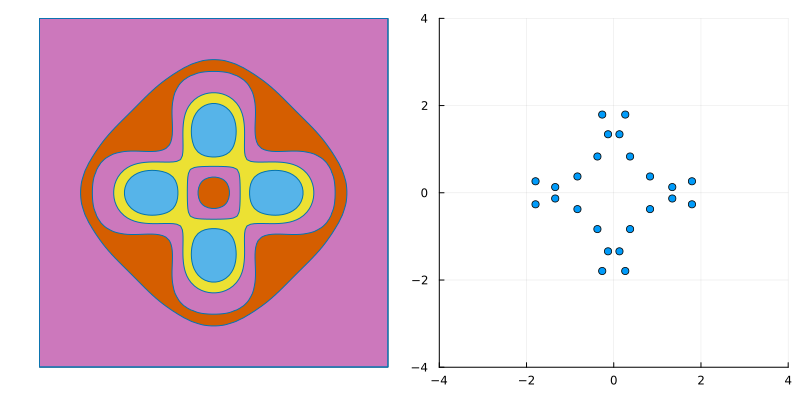

In [9]:
# animatepattern(ngon, flip, X, a, k, ω, t, width, levels, colormap, speed=16, saveframes=false)
animatepattern(ngon, true, X, a, k, ω, t, width, levels, colormap, speed, false) 